In [14]:
import os
import cv2
import json
import numpy as np

In [15]:
def get_dataset_paths(data_path):
    '''
    Get the file paths for the real and synthetic data
    :param data_path: The path to the data
    :return: real_data_files: The file paths for the real data
             synthetic_data_files: The file paths for the synthetic data
    '''
    # Load all the image file paths for real and synthetic data
    synthetic_data = os.path.join(data_path, "ThisPersonDoesNotExist")
    synthetic_data_files = []
    for dir in os.listdir(synthetic_data):
        synthetic_data_files.extend([os.path.join(synthetic_data, dir, f) for f in os.listdir(os.path.join(synthetic_data, dir))])

    # Load the json subset of the real data
    with open("real_faces_subset.json") as f:
        real_data_json = json.load(f)
    
    # Build the real data file paths
    real_data_files = []
    for file_entry in real_data_json['files']:
        real_data_files.append(os.path.join(data_path, file_entry))
    
    return real_data_files, synthetic_data_files


def load_and_resize_images(file_paths, size=(64, 64)):
    '''
    Load the images from the file paths
    :param file_paths: The file paths to the images
    :return: The images in numpy array format
    '''
    images = []
    for file_path in file_paths:
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size)
        images.append(image)
    return np.array(images)


def shuffle_data(X, y):
    '''
    Shuffles the data
    :param X: The data
    :param y: The labels
    :return: The shuffled data and labels
    '''
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]


def split_data(data):
    '''
    Split the data into training, validation and test sets (60 - 20 - 20 split)
    :param data: The data to split
    :return: The training, validation and test sets
    '''
    return np.split(data, [int(0.6 * len(data)), int(0.8 * len(data))])


def augment_data(X_images, augmentations, n_augmentations=5):
    '''
    Augments the data by selecting from a random augmentation from a set of augmentations to apply to a random image
    This is repeated n_augmentations times
    :param X_images: The images in numpy array format
    :param augmentations: The set of augmentations to apply
    :param n_augmentations: The number of augmentations to apply
    :return: X_images: Dataset with augmented images in numpy array format
    '''
    if n_augmentations == 0:
        return X_images

    augmented_images = []
    for i in range(n_augmentations):
        random_index = np.random.randint(0, len(X_images))
        random_augmentation = np.random.choice(augmentations)
        augmented_images.append(random_augmentation(X_images[random_index]))
    
    return np.concatenate((X_images, augmented_images), axis=0)


def add_random_noise(image):
    '''
    Adds random noise to the image
    :param image: The image to add noise to
    :return: The noisy image
    '''
    # Normalize the image to [0, 1]
    normalized_image = image / 255
    # Add Gaussian noise
    noise = np.random.normal(0, 0.05, normalized_image.shape)
    noisy_image = normalized_image + noise
    # Clip the noisy image to [0, 1]
    noisy_image_clipped = np.clip(noisy_image, 0, 1)
    # Convert the noisy image back to [0, 255]
    return (noisy_image_clipped * 255).astype(np.uint8)


def jitter_image(image):
    '''
    Randomly shifts the image either up, down, left or right by a random small amount of pixels
    :param image: The image to jitter
    :return: The jittered image
    '''
    # Choose a random direction to shift the image
    direction = np.random.choice(["up", "down", "left", "right"])
    # Choose a random amount to shift the image
    amount = np.random.randint(1, 10)
    # Sample a random pixel on the direction edge for the color to use
    # This does not look as good as it sounds
    if direction == "up":
        color = image[0, np.random.randint(0, image.shape[1])]
    elif direction == "down":
        color = image[-1, np.random.randint(0, image.shape[1])]
    elif direction == "left":
        color = image[np.random.randint(0, image.shape[0]), 0]
    else:
        color = image[np.random.randint(0, image.shape[0]), -1]

    # Shift the image and replace the empty space with border color pixels
    if direction == "up":
        jittered_image = np.vstack((np.full((amount, image.shape[1], 3), color), image[:-amount]))
    elif direction == "down":
        jittered_image = np.vstack((image[amount:], np.full((amount, image.shape[1], 3), color)))
    elif direction == "left":
        jittered_image = np.hstack((np.full((image.shape[0], amount, 3), color), image[:, :-amount]))
    else:
        jittered_image = np.hstack((image[:, amount:], np.full((image.shape[0], amount, 3), color)))
    return jittered_image

In [16]:
real_files, synthetic_files = get_dataset_paths("dataset")
real_images = load_and_resize_images(real_files)
synthetic_images = load_and_resize_images(synthetic_files)

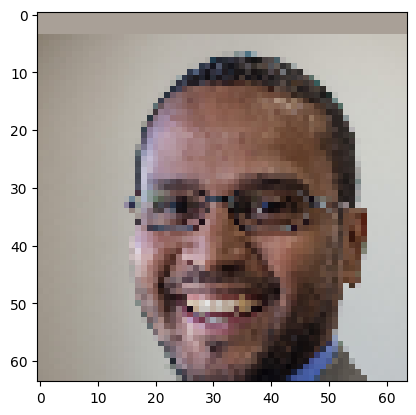

In [20]:
from matplotlib import pyplot as plt
img = real_images[0]
augmentations = [   lambda image: cv2.flip(image, 1),
                    lambda image: add_random_noise(image),
                    lambda image: jitter_image(image)]
img = augmentations[2](img)
plt.imshow(img)
# Not using jitter for now
augmentations = [lambda image: cv2.flip(image, 1),
                 lambda image: add_random_noise(image)]

In [21]:
target_dataset_size = 10000
real_images = augment_data(real_images, augmentations, target_dataset_size - len(real_images))
synthetic_images = augment_data(synthetic_images, augmentations, target_dataset_size - len(synthetic_images))
print(len(real_images))
print(len(synthetic_images))

10000
10000


In [22]:
# Combined Data with associated labels
X = np.concatenate((real_images, synthetic_images))
y = np.concatenate((np.ones(len(real_images)), np.zeros(len(synthetic_images))))

In [23]:
X, y = shuffle_data(X, y)

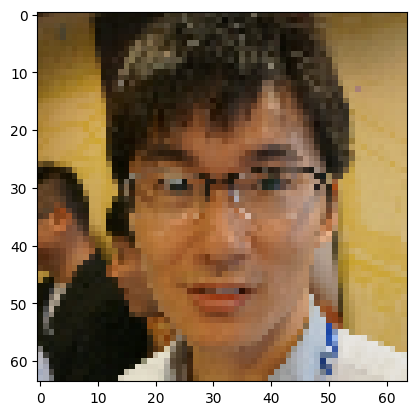

In [25]:
img = X[0]
plt.imshow(img)

In [26]:
X_train, X_val, X_test = split_data(X)
y_train, y_val, y_test = split_data(y)

Epoch [1/40], Train Loss: 0.6977, Val Loss: 0.6616
Epoch [2/40], Train Loss: 0.6478, Val Loss: 0.6180
Epoch [3/40], Train Loss: 0.6209, Val Loss: 0.5856
Epoch [4/40], Train Loss: 0.5937, Val Loss: 0.5955
Epoch [5/40], Train Loss: 0.5757, Val Loss: 0.6151
Epoch [6/40], Train Loss: 0.5407, Val Loss: 0.6001
Epoch [7/40], Train Loss: 0.5265, Val Loss: 0.5529
Epoch [8/40], Train Loss: 0.5102, Val Loss: 0.5246
Epoch [9/40], Train Loss: 0.4999, Val Loss: 0.5069
Epoch [10/40], Train Loss: 0.4884, Val Loss: 0.5170
Epoch [11/40], Train Loss: 0.4668, Val Loss: 0.5714
Epoch [12/40], Train Loss: 0.4579, Val Loss: 0.4911
Epoch [13/40], Train Loss: 0.4390, Val Loss: 0.4878
Epoch [14/40], Train Loss: 0.4385, Val Loss: 0.6565
Epoch [15/40], Train Loss: 0.4237, Val Loss: 0.7200
Epoch [16/40], Train Loss: 0.4145, Val Loss: 0.5188
Epoch [17/40], Train Loss: 0.3990, Val Loss: 0.4978
Epoch [18/40], Train Loss: 0.3898, Val Loss: 0.5054
Epoch [19/40], Train Loss: 0.3711, Val Loss: 0.4882
Epoch [20/40], Train 

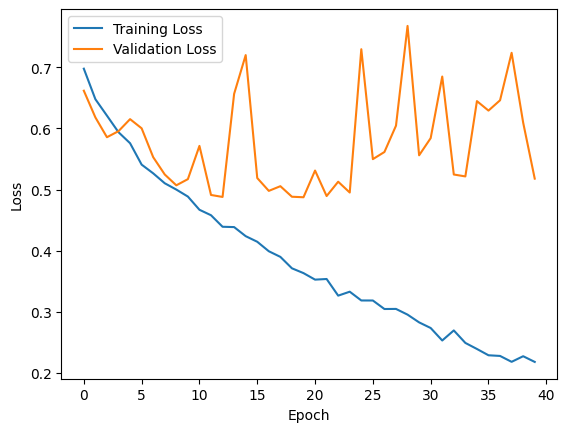

In [30]:
import matplotlib.pyplot as plt

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 128),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        output = self.model(x)
        return output
    
def train_discriminator(X_train, y_train, X_val,y_val, X_test, y_test, batch_size, n_epochs, learning_rate):
    X_train = X_train / 255.0
    X_val = X_val / 255.0

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]  
    model = Discriminator(input_size=input_size)
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    train_losses = []
    val_losses = []

    # 훈련 시작
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels.view(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_losses.append(train_loss / len(train_loader.dataset))
        
        # 검증
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_function(outputs, labels.view(-1, 1))
                val_loss += loss.item() * images.size(0)
        val_losses.append(val_loss / len(val_loader.dataset))
        
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # 손실 그래프 그리기
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

# 데이터 준비와 모델 훈련 부분은 실제 데이터셋을 기준으로 적절히 수정해야 합니다.
model = train_discriminator(X_train, y_train, X_val,y_val, X_test, y_test, batch_size=16, n_epochs=40, learning_rate=0.001)


Epoch [1/30], Train Loss: 0.7706, Val Loss: 0.6685
Epoch [2/30], Train Loss: 0.6773, Val Loss: 0.6413
Epoch [3/30], Train Loss: 0.6583, Val Loss: 0.6791
Epoch [4/30], Train Loss: 0.6371, Val Loss: 0.6104
Epoch [5/30], Train Loss: 0.6225, Val Loss: 0.5931
Epoch [6/30], Train Loss: 0.6209, Val Loss: 0.5357
Epoch [7/30], Train Loss: 0.5926, Val Loss: 0.7105
Epoch [8/30], Train Loss: 0.5531, Val Loss: 0.5645
Epoch [9/30], Train Loss: 0.5357, Val Loss: 0.5722
Epoch [10/30], Train Loss: 0.5403, Val Loss: 0.5077
Epoch [11/30], Train Loss: 0.5170, Val Loss: 0.5571
Epoch [12/30], Train Loss: 0.5087, Val Loss: 0.5541
Epoch [13/30], Train Loss: 0.5241, Val Loss: 0.4928
Epoch [14/30], Train Loss: 0.4727, Val Loss: 0.6996
Epoch [15/30], Train Loss: 0.4744, Val Loss: 0.5604
Epoch [16/30], Train Loss: 0.4825, Val Loss: 0.5331
Epoch [17/30], Train Loss: 0.4540, Val Loss: 0.5537
Epoch [18/30], Train Loss: 0.4523, Val Loss: 0.6469
Epoch [19/30], Train Loss: 0.4245, Val Loss: 0.5004
Epoch [20/30], Train 

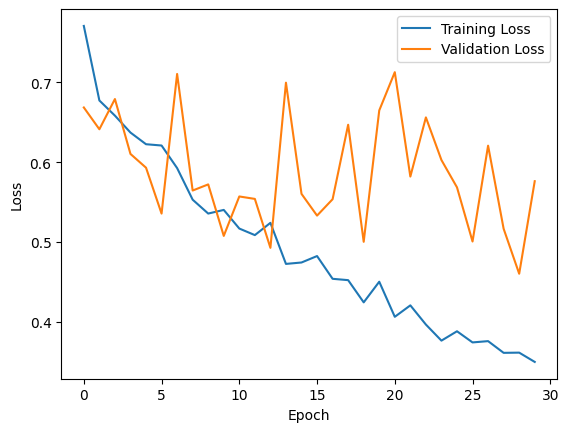

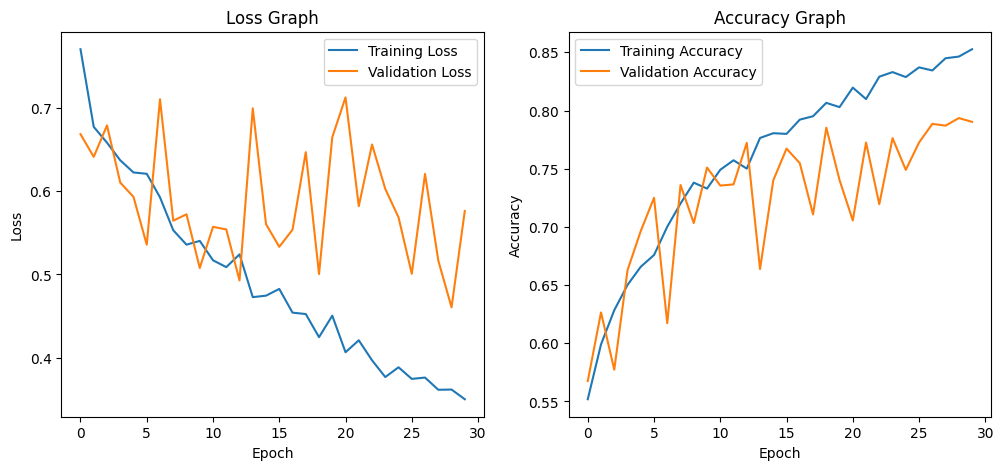

In [33]:
import matplotlib.pyplot as plt

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 128),
            nn.Dropout(0.3),
            nn.LeakyReLU(0.2),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        output = self.model(x)
        return output
    
def calculate_accuracy(y_pred, y_true):
    predicted = y_pred.round()  
    correct = (predicted == y_true).float() 
    accuracy = correct.sum() / len(correct) 
    return accuracy

def fc_classification(X_train, y_train, X_val,y_val, X_test, y_test, batch_size, n_epochs, learning_rate):
    X_train = X_train / 255.0
    X_val = X_val / 255.0

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]  
    model = Discriminator(input_size=input_size)
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # 훈련 시작
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_accuracy = 0
        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels.view(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            acc = calculate_accuracy(outputs, labels.view(-1, 1))
            train_accuracy += acc.item() * images.size(0)
        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracy /= len(train_loader.dataset)
        train_accuracies.append(train_accuracy)
        
        # 검증
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_function(outputs, labels.view(-1, 1))
                val_loss += loss.item() * images.size(0)
                acc = calculate_accuracy(outputs, labels.view(-1, 1))
                val_accuracy += acc.item() * images.size(0)
                
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracy /= len(val_loader.dataset)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Graph')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Graph')
    plt.legend()

    plt.show()

    return model

# 데이터 준비와 모델 훈련 부분은 실제 데이터셋을 기준으로 적절히 수정해야 합니다.
model = fc_classification(X_train, y_train, X_val,y_val, X_test, y_test, batch_size=16, n_epochs=30, learning_rate=0.002)
